# Análise de Risco de Crédito

## Case - Modelo preditivo para aprovação de crédito

Modelos de score de crédito calculam a probabilidade de inadimplência e são uma das
principais ferramentas utilizadas por diversas empresas para aprovar ou negar um crédito.
O objetivo deste desafio é criar um modelo preditivo calculando a probabilidade de
inadimplência de cada novo pedido de crédito.


### Dados:
Cada linha representa um cliente e as colunas representam os dados (informações) desses
clientes.
A variável resposta é a coluna inadimplente, que indica se o tomador veio a se tornar
inadimplente(1) ou não(0).
As variáveis da base de dados são descritas abaixo:

* idade: A idade do cliente..
* numero_de_dependentes: O número de pessoas dependentes do cliente.
* salario_mensal: Salário mensal do cliente.
* numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o
cliente possui em aberto.
* numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais
de 90 dias em atraso.
* util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite
dele, de linhas de crédito que não são seguradas por qualquer bem do tomador
e.g: imoveis, carros etc.
* vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30
e 59 dias, o pagamento de um empréstimo.
* razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito =
Dividas/Patrimônio
* numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.
* numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente
atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.

**ps: Os dados desta análise foram retirados de processo seletivo e devidamente alterados para que fossem tornados públicos**

In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   

plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from tqdm import tqdm

<Figure size 720x540 with 0 Axes>

## Pré processando e analisando os dados
- Tratar os valores nulos
- Verificar os outliers

In [285]:
emprestimos = pd.read_csv('treino.csv')

In [286]:
len(emprestimos)

110000

In [287]:
n_inadimplentes = emprestimos.loc[emprestimos.inadimplente == 1].count()
n_inadimplentes = n_inadimplentes.iloc[0]

n_bons_pagadores = emprestimos.loc[emprestimos.inadimplente == 0].count()
n_bons_pagadores = n_bons_pagadores.iloc[0]

desbalanceamento = n_inadimplentes/n_bons_pagadores
desbalanceamento

0.07140422133263205

--------
**Os dados estão severamente desbalanceados, caso o modelo gerado por regressão logística não seja satisfatório, considerarei balanceá-los.**

----

In [288]:
## Funções genéricas para tratamento de dados
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])


def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

#Lidando com outliers
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x


In [289]:
emprestimos.apply(lambda x: var_summary(x)).T


,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
inadimplente,110000.00,0.00,7331.00,0.07,0.00,0.25,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
util_linhas_inseguras,110000.00,0.00,652297.74,5.93,0.16,252.30,63656.28,0.00,0.00,0.00,0.00,0.03,0.16,0.56,0.98,1.00,1.09,50708.00
idade,110000.00,0.00,5748120.00,52.26,52.00,14.77,218.10,0.00,24.00,29.00,33.00,41.00,52.00,63.00,72.00,78.00,87.00,109.00
vezes_passou_de_30_59_dias,110000.00,0.00,46646.00,0.42,0.00,4.24,17.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,4.00,98.00
razao_debito,110000.00,0.00,39030594.74,354.82,0.37,2074.14,4302058.49,0.00,0.00,0.00,0.03,0.18,0.37,0.87,1265.00,2464.05,5000.01,329664.00
salario_mensal,88237.00,21763.00,585665240.00,6637.41,5400.00,13383.95,179130142.84,0.00,0.00,1300.00,2018.60,3400.00,5400.00,8225.00,11666.00,14593.40,25000.00,3008750.00
numero_linhas_crdto_aberto,110000.00,0.00,929013.00,8.45,8.00,5.14,26.41,0.00,0.00,2.00,3.00,5.00,8.00,11.00,15.00,18.00,24.00,58.00
numero_vezes_passou_90_dias,110000.00,0.00,29695.00,0.27,0.00,4.22,17.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,98.00
numero_emprestimos_imobiliarios,110000.00,0.00,112188.00,1.02,1.00,1.14,1.29,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,3.00,4.00,54.00
numero_de_vezes_que_passou_60_89_dias,110000.00,0.00,26828.00,0.24,0.00,4.20,17.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,98.00


Avaliando os dados acima percebemos <b>alguns outliers</b> no data set entre os percentis **99 e 100.**</br>
Remover os outliers é considerado uma boa pratica pois os mesmos podem interferir negativamente em nosso modelo.

As únicas colunas com valores nulos são **salario_mensal** e **numero_de_dependentes**. Considerarei ambas como sendo a média de cada coluna:



In [290]:
emprestimos=emprestimos.apply(lambda x: outlier_capping(x))
emprestimos=emprestimos.apply(lambda x: Missing_imputation(x))

In [370]:
emprestimos.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

In [292]:
variaveis=[key for key in dict(emprestimos.dtypes) if dict(emprestimos.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

<AxesSubplot:>

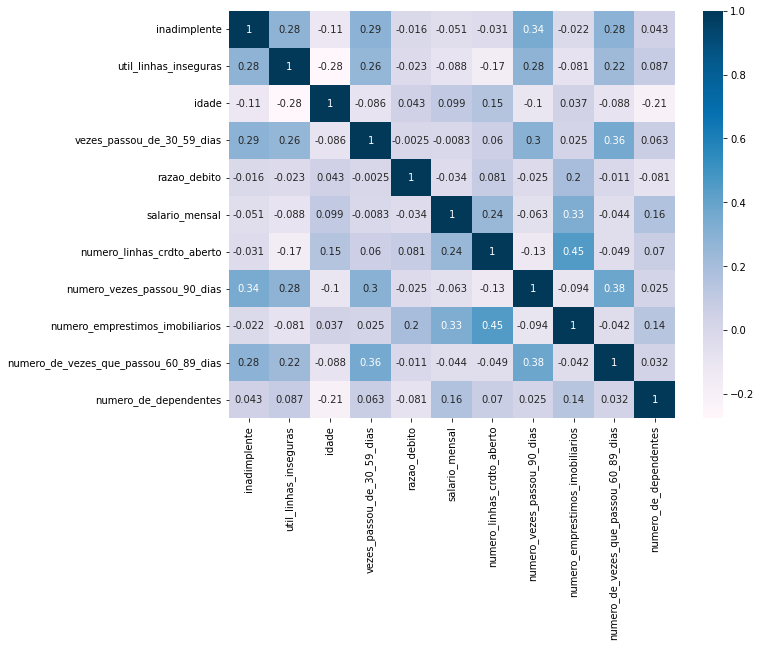

In [293]:
sns.heatmap(emprestimos.corr(), annot=True, cmap='PuBu')

A correlação acima mostra que não há **nenhuma forte correlação entre as variáveis**, tendo as correlações mais fortes entre **numero_emprestimos_imobiliarios** e  **numero_linhas_crdto_aberto**. Também para **numero_de_vezes_que_passou_60_89_dias** e **numero_vezes_passou_90_dias**.

Percebemos que **numero_vezes_passou_90_dias** e **numero_de_vezes_que_passou_60_89_dias** tem uma maior correlação com a **inadimplencia**, mas não chega a ser alta.

Tentarei entender o impacto de cada variavel na variavel dependente inadimplencia utilizando **Box Plots**:

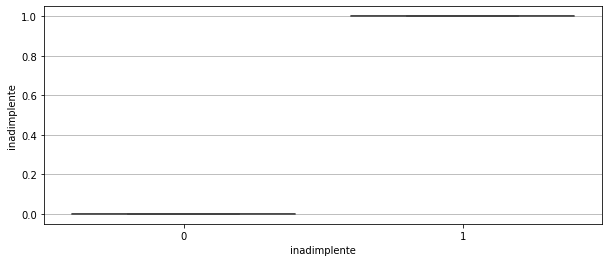

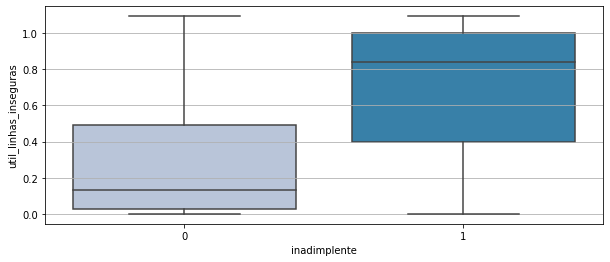

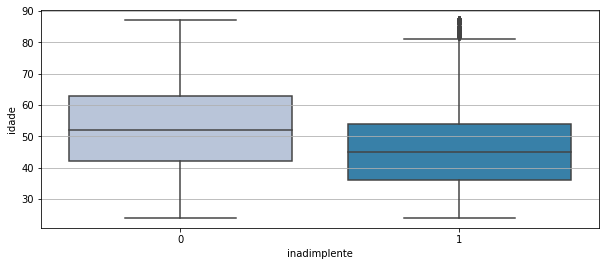

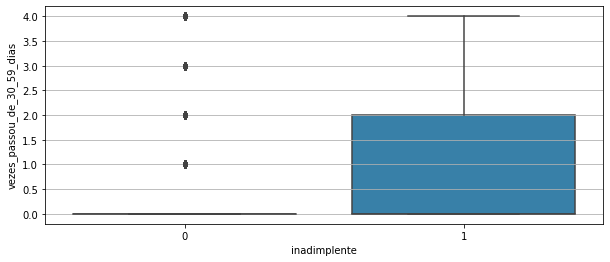

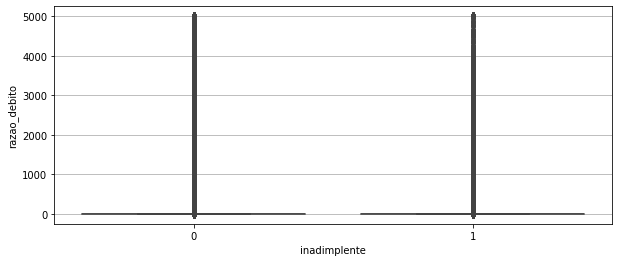

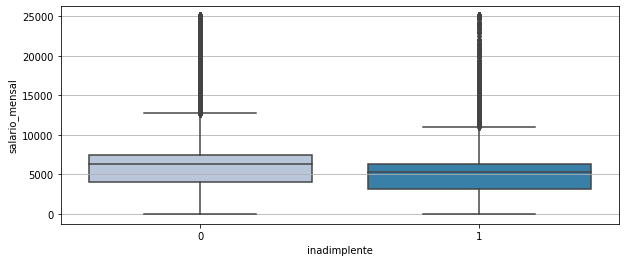

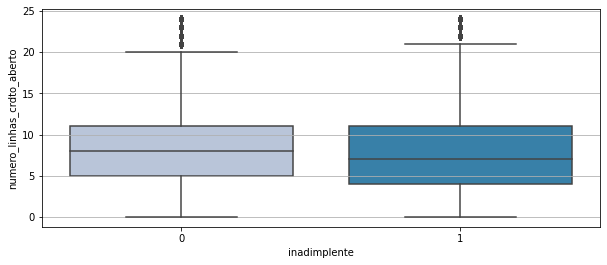

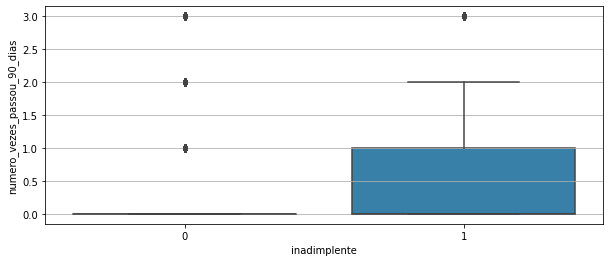

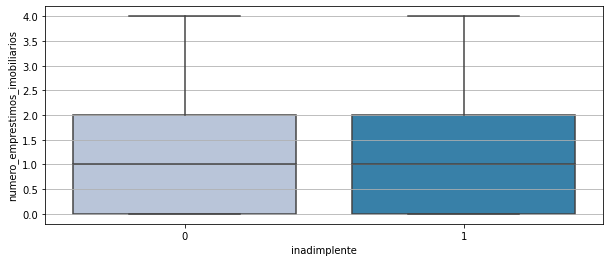

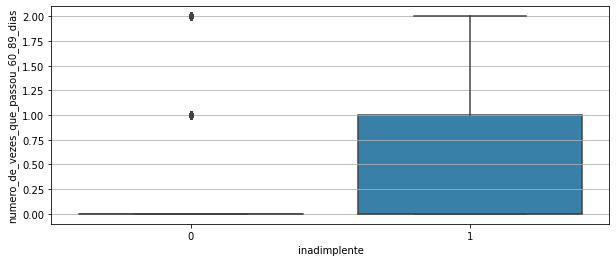

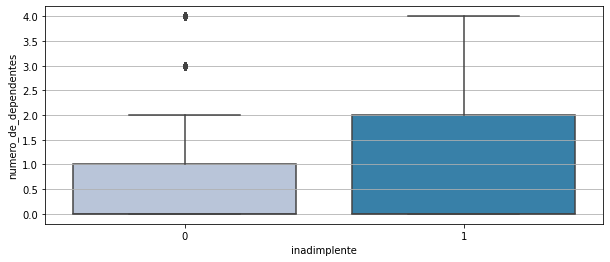

In [294]:
bp = PdfPages('BoxPlots with default Split.pdf')

for var in variaveis:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='inadimplente', y=var, data = emprestimos, palette='PuBu')
    bp.savefig(fig)
bp.close()

Vamos avaliar as plotagens acima e ver se encontramos informações importantes:

* **util_linhas_inseguras** - Claramente pessoas que usam acima de 50% das suas linhas de crédito não seguradas tendem a ser mais inadimplentes

* **idade** - Há uma indicação que pessoas com menos idade tendem a ser mais inadimplentes.

* **vezes_passou_de_30_59_dias** - Como esperado, pessoas que atrasam o pagamento de suas dividas tendem a ser inadimplentes

* **razao_debito** - Muitos outliers, endereçar essa variável mais tarde

* **salario_mensal** - Também muitos outliers, porém há uma tendencia de pessoas com rendas menores serem inadimplentes

* **numero_linhas_crdto_aberto** - Distribuições parecidas, porém a mediana do número de linhas abertas é levemente menor para inadimplentes

* **numero_vezes_passou_90_dias** - Pessoas que não atrasam o pagamento de suas dívidas por mais de 90 dias tendem a ser menos inadimplentes

* **numero_emprestimos_imobiliarios** - Nenhuma diferença entre inadimplentes e bons pagadores

* **numero_de_vezes_que_passou_60_89_dias** - Pessoas que não atrasam o pagamento de suas dívidas por mais de 60 dias tendem a ser menos inadimplentes

* **numero_de_dependentes**  - Inadimplentes tem em média mais dependentes do que os pagadores


As interpretações acima colhidas confirmam algumas presunções basicas acerca do tema, ao menos no data set fornecido

### Bivariate Analysis - TTest<br>

O TTest abaixo tem como objetivo avaliar a relação entre a **variável dependente inadimplente** com todas as **variáveis independentes** no data set. Isso nos ajudará a identificar se alguma variável esta enviesada a algum segmento da variável dependente

Minha hipótese H0 é que as amostras independentes de cada variável não são tendenciosas / relacionadas à variável dependente, ou seja, 'inadimplente'. No entanto, se o valor P for maior, as variáveis são independentes e não são significativas para o modelo. Essas variáveis poderão ser excluídas.

In [295]:
tstats_df = pd.DataFrame()
for var in emprestimos.columns.difference(['inadimplente']):
    tstats=stats.ttest_ind(emprestimos[emprestimos.inadimplente==1][var],emprestimos[emprestimos.inadimplente==0][var])
    temp = pd.DataFrame([var, tstats[0], tstats[1]]).T
    temp.columns = ['Nome da Variável', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
print(tstats_df)


                        Nome da Variável T-Statistic P-Value
0                                  idade      -38.28    0.00
1                  numero_de_dependentes       14.31    0.00
2  numero_de_vezes_que_passou_60_89_dias       97.92    0.00
3        numero_emprestimos_imobiliarios       -7.40    0.00
4             numero_linhas_crdto_aberto      -10.34    0.00
5            numero_vezes_passou_90_dias      121.54    0.00
6                           razao_debito       -5.22    0.00
7                         salario_mensal      -16.80    0.00
8                  util_linhas_inseguras       96.68    0.00
9             vezes_passou_de_30_59_dias       98.92    0.00


**Como todos os P-values são 0 podemos considerar que não é nescessário remover nenhuma variável.**

### Visualização da importância da variável


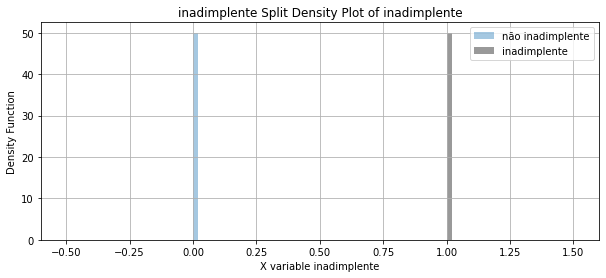

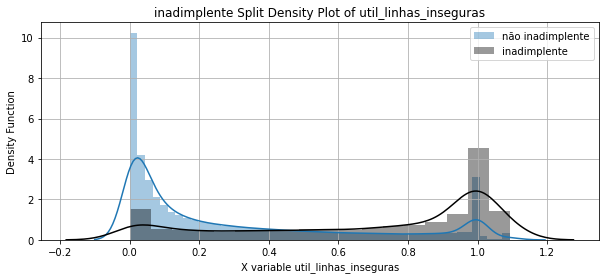

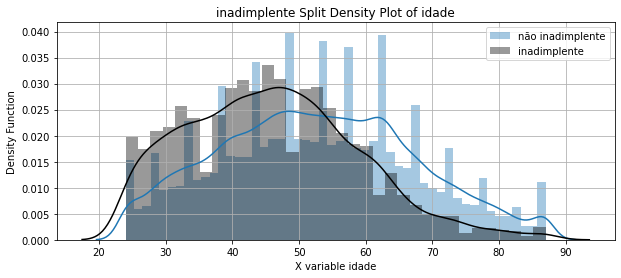

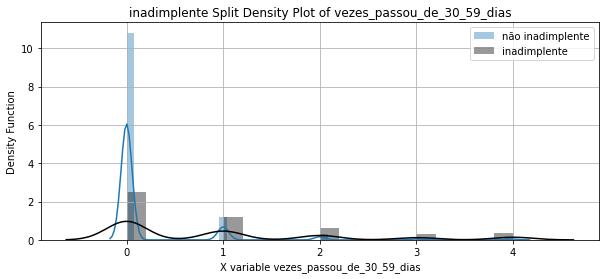

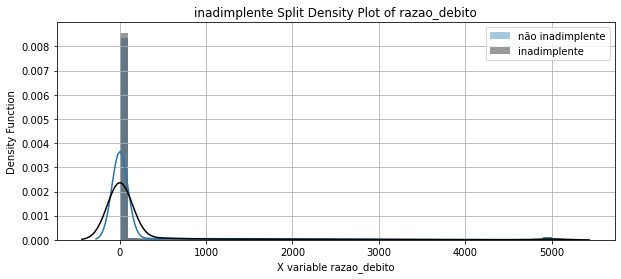

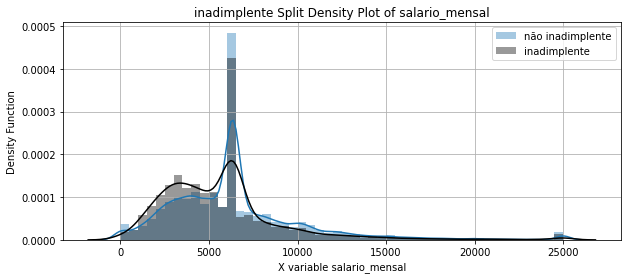

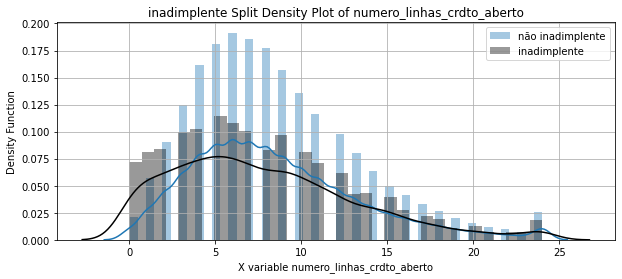

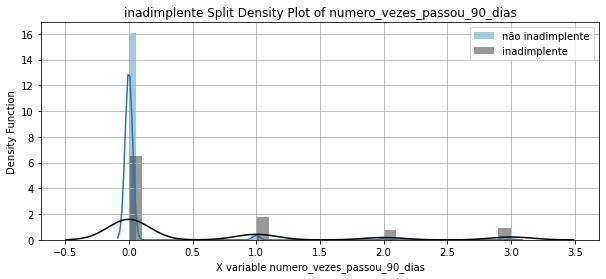

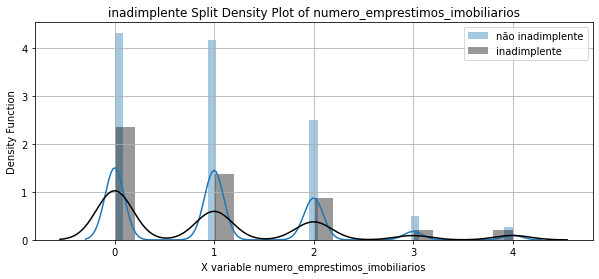

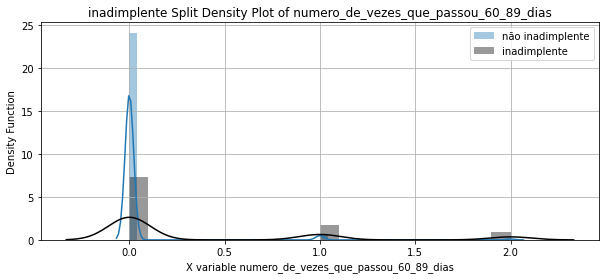

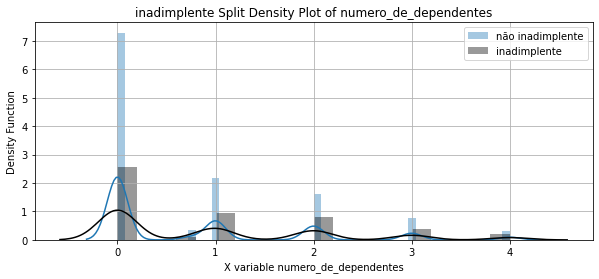

In [13]:
import warnings
warnings.filterwarnings("ignore")

for var in variaveis:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.distplot(emprestimos[emprestimos['inadimplente']==0][var], label='não inadimplente', color='tab:blue', hist=True, norm_hist=False)
    sns.distplot(emprestimos[emprestimos['inadimplente']==1][var], label='inadimplente', color='Black', hist=True, norm_hist=False)
    plt.xlabel(str("X variable ") + str(var) )
    plt.ylabel('Density Function')
    plt.title(str('inadimplente Split Density Plot of ')+str(var))
    plt.legend()

Apenas razão débito parece não influenciar na inadimplência, porém como estou lidando com poucas variáveis escolhi não remover nenhuma dos modelos.

## 1. Regressão logística via modelo estatístico

#### Dividindo train e test

In [423]:
train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)

### Gerando modelo e resultados

In [424]:
logreg = sm.logit(formula='inadimplente ~ ' + "+".join(train_features), data=train_X_y)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.187181
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           inadimplente   No. Observations:                77000
Model:                          Logit   Df Residuals:                    76989
Method:                           MLE   Df Model:                           10
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.2424
Time:                        18:44:56   Log-Likelihood:                -14413.
converged:                       True   LL-Null:                       -19025.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.4687      0.079    -43.825      0.000      -3.624      -3.314
idade                                    -0.0177      0.001    -13.342      0.000      -0.020      -0.015
numero_de_dependentes                     0.0361      0.015      2.453      0.014       0.007       0.065
numero_de_vezes_que_passou_60_89_dias     0.6174      0.036     17.074      0.000       0.547       0.688
numero_emprestimos_imobiliarios           0.0863      0.019      4.453      0.000       0.048       0.124
numero_linhas_crdto_aberto                0.0459      0.004     12.110      0.000       0.038       0.053
numero_vezes_passou_90_dias               0.7697      0.025     30.874      0.000       0.721       0.819
razao_debito                          -4.181e-05   1.88e-05     -2.228      0.026   -7.86e-05   -5.04e-06
salario_mensal                         -3.69e-05   4.98e-06     -7.405      0.000   -4.67e-05   -2.71e-05
util_linhas_inseguras                     2.0636      0.048     42.557      0.000       1.969       2.159
vezes_passou_de_30_59_dias                0.4271      0.017     25.238      0.000       0.394       0.460
=========================================================================================================
"""

In [425]:
AUC = metrics.average_precision_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features]))

print('PR-AUC is -> ' + str(AUC))

PR-AUC is -> 0.37386064358599147


In [426]:
AUC = metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features]))

print('Train AUC é -> ' + str(AUC))

AUC = metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features]))

print('Test AUC é -> ' + str(AUC))

Train AUC é -> 0.8528741156267109
Test AUC é -> 0.8455877013708183


In [427]:
train_gini = 2*metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features])) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features])) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.7057482312534218
The Gini Index for the model built on the Test Data is :  0.6911754027416366


In [428]:
train_predicted_prob = pd.DataFrame(result.predict(train_X_y[train_features]))
train_predicted_prob.columns = ['prob']
train_actual = train_X_y['inadimplente']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict(test_X_y[train_features]))
test_predicted_prob.columns = ['prob']
test_actual = test_X_y['inadimplente']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

In [429]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()
    
    for cut_off in tqdm(np.linspace(0,1,50)):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:20<00:00, 10.02s/it]


In [430]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.06,0.78,0.77,1.55


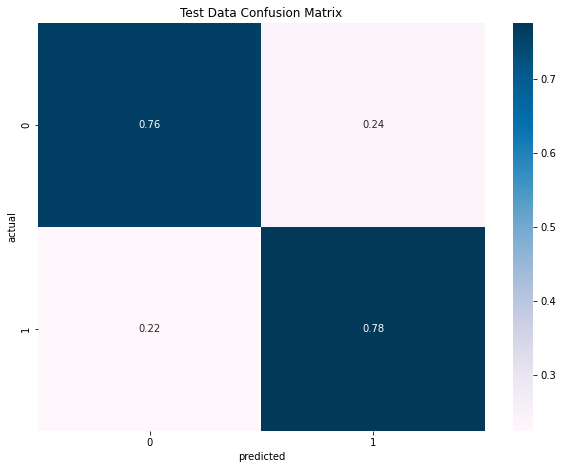

In [431]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.06 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted'], normalize='index'), annot=True, cmap='PuBu')
plt.title('Test Data Confusion Matrix')
plt.show()

train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.06 else 0)


In [432]:
print("A pontuação geral de precisão para a Train Data é: ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("A pontuação geral de precisão para a Test Data é: ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

A pontuação geral de precisão para a Train Data é:  0.7624805194805194
A pontuação geral de precisão para a Test Data é:  0.760969696969697


**Pouca diferença entre train e test nos indica que não há overfiting!**

#### Decile Analysis

In [433]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
19925,0,0.03,0,5
48272,0,0.03,0,5
25771,0,0.04,0,6
107971,0,0.07,1,7
51063,0,0.01,0,0


In [434]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)
df

,Deciles,actual
Deciles,,
9,69300,2729
8,61600,877
7,53900,572
6,46200,363
5,38500,244
4,30800,148
3,23100,94
2,15400,83
1,7700,53


O modelo de Regressão Logística parece interpretar bem o problema proposto. Métricas como **AUC, Overral Score, Confusion Matrix** e a **Decile Analysis** me indicam que o modelo performa bem, porém, como dito préviamente, o dataset está desbalanceado, e acho que vale a pena balanceá-lo para descobrir se conseguimos algum ganho na **AUC**. Caso não haja ganho, procurarei modelos preditivos diferentes com melhores métricas.

-----------

## 2. Regressão logística via modelo estatístico com o data set balanceado

Não é sempre que dados desbalanceados apresentam um problema para nosso modelo, mas nesse caso específico queremos melhorar a previsão da condição rara no dados - o inadimplente - e para isso acredito que ao balancear o conjunto de dados eu talvez obtenha melhores resultados


In [435]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

from collections import Counter


Para performar o balanceamento utilizarei como base a função **SMOTE**. 

Com base em sugestão do paper original a apresentar a função, combinarei o **oversample** de inadimplentes utilizando o SMOTE com um **undersample** dos bons pagadores.

Primeiro farei o **oversample** até os inadimplentes serem **10%** da base, e depois farei o **undersample** para que bons pagadores sejam **50%** mais frequentes que inadimplentes

#### Dividindo train e test e realizando o balanceamento

In [499]:
train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)

In [500]:
# transformar o data set
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X = train_X_y.drop(labels='inadimplente', axis=1)
y =  train_X_y['inadimplente']
counter = Counter(y)
print('Previous', counter)
X, y = pipeline.fit_resample(X, y)

counter = Counter(y)
print('New' ,counter)

Previous Counter({0: 71804, 1: 5196})
New Counter({0: 14360, 1: 7180})


-----------------------


### Gerando Modelo e resultados 

In [501]:
train_y = pd.DataFrame(y, columns=['inadimplente'])
train_X_y = train_y.merge(X, how='left', left_index=True, right_index=True)

In [502]:
logreg = sm.logit(formula='inadimplente ~ ' + "+".join(train_features), data=train_X_y)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.458286
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           inadimplente   No. Observations:                21540
Model:                          Logit   Df Residuals:                    21529
Method:                           MLE   Df Model:                           10
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.2800
Time:                        19:48:30   Log-Likelihood:                -9871.5
converged:                       True   LL-Null:                       -13711.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -1.6008      0.085    -18.863      0.000      -1.767      -1.434
idade                                    -0.0197      0.001    -13.918      0.000      -0.022      -0.017
numero_de_dependentes                     0.0487      0.017      2.948      0.003       0.016       0.081
numero_de_vezes_que_passou_60_89_dias     0.6880      0.053     12.917      0.000       0.584       0.792
numero_emprestimos_imobiliarios          -0.0248      0.021     -1.171      0.242      -0.066       0.017
numero_linhas_crdto_aberto                0.0487      0.004     11.763      0.000       0.041       0.057
numero_vezes_passou_90_dias               0.8870      0.041     21.879      0.000       0.808       0.966
razao_debito                          -4.274e-06   1.99e-05     -0.215      0.830   -4.33e-05    3.48e-05
salario_mensal                        -1.705e-05    5.1e-06     -3.345      0.001    -2.7e-05   -7.06e-06
util_linhas_inseguras                     2.1893      0.051     42.652      0.000       2.089       2.290
vezes_passou_de_30_59_dias                0.5216      0.024     22.170      0.000       0.475       0.568
=========================================================================================================
"""

In [503]:
AUC = metrics.average_precision_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features]))

print('PR-AUC is -> ' + str(AUC))

PR-AUC is -> 0.3617625514827067


In [504]:
AUC = metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features]))

print('Train AUC é -> ' + str(AUC))

AUC = metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features]))

print('Test AUC é -> ' + str(AUC))

Train AUC é -> 0.847240943195661
Test AUC é -> 0.8460855102544851


In [505]:
train_gini = 2*metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features])) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features])) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.694481886391322
The Gini Index for the model built on the Test Data is :  0.6921710205089702


In [506]:
train_predicted_prob = pd.DataFrame(result.predict(train_X_y[train_features]))
train_predicted_prob.columns = ['prob']
train_actual = train_X_y['inadimplente']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict(test_X_y[train_features]))
test_predicted_prob.columns = ['prob']
test_actual = test_X_y['inadimplente']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in  tqdm(np.linspace(0,1,50)):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.69s/it]


In [507]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.29,0.79,0.75,1.54


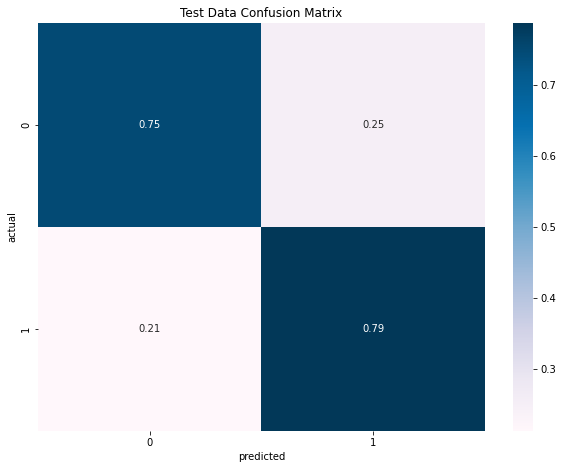

In [511]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted'], normalize='index'), annot=True, cmap='PuBu')
plt.title('Test Data Confusion Matrix')
plt.show()

train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)


In [512]:
print("A pontuação geral de precisão para a Train Data é: ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("A pontuação geral de precisão para a Test Data é: ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

A pontuação geral de precisão para a Train Data é:  0.7624883936861653
A pontuação geral de precisão para a Test Data é:  0.7492727272727273


Ao compararmos a ***AUC(Area under the curve)*** percebemos que o modelo **balanceado** performa **levemente melhor** que o modelo **não balanceado**. Por conta disso considerarei, por enquanto, o **modelo de regressão logística balanceado** como o a **melhor opção**.

---------

**O modelo baseado em regressão logística até apresenta boa performance. Mas será que seríamos capazes de alcançar resultados ainda mais acurados? Para descobrir utilizarei a biblioteca lazy predict para descobrir quais modelos se encaixam melhor em nosso problema.**

## 3. Encontrando melhores modelos

In [150]:
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import shuffle
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

from collections import Counter

In [151]:
train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)

In [152]:
train_y = train_X_y['inadimplente']
train_X = train_X_y[train_features]

test_y = test_X_y['inadimplente']
test_X = test_X_y[train_features]


In [220]:
# reduzindo o data set por undersampling para otimizar o desempenho do lazy predict
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('u', under)]
pipeline = Pipeline(steps=steps)

counter = Counter(train_y)
print('Antes:', counter)
train_X, train_y = pipeline.fit_resample(train_X, train_y)

counter = Counter(train_y)
print('Agora:',counter)

Antes: Counter({0: 71804, 1: 5196})
Agora: Counter({0: 10392, 1: 5196})


In [157]:
### fitting data in LazyRegressor because here we are solving Regression use case. 
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, predictions=True)

In [158]:
### fitting data in LazyClassifier
models, lazy_predictions = clf.fit(train_X, test_X, train_y, test_y)
### lets check which model did better on Breast Cancer data set


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [20:35<00:00, 42.61s/it]


In [174]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.87,0.77,0.77,0.89,1.11
NearestCentroid,0.84,0.76,0.76,0.87,0.53
RandomForestClassifier,0.87,0.76,0.76,0.89,4.25
XGBClassifier,0.86,0.75,0.75,0.89,2.48
BernoulliNB,0.87,0.75,0.75,0.89,0.12
ExtraTreesClassifier,0.86,0.75,0.75,0.89,2.89
SVC,0.89,0.75,0.75,0.90,15.86
AdaBoostClassifier,0.89,0.74,0.74,0.90,1.52
SGDClassifier,0.89,0.74,0.74,0.91,0.29


-----

## 4. LGBMClassifier

In [334]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [335]:
# define data set

train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)



In [336]:
train_y = train_X_y['inadimplente']
train_X = train_X_y[train_features]

test_y = test_X_y['inadimplente']
test_X = test_X_y[train_features]


In [337]:
# fit the model on the whole data set
model = LGBMClassifier()
result = model.fit(train_X, train_y)

In [331]:
AUC = metrics.average_precision_score(train_y, result.predict(train_X))

print('PR-AUC is -> ' + str(AUC))

PR-AUC is -> 0.22573098522658433


In [332]:
AUC = metrics.roc_auc_score(train_y, result.predict(train_X))

print('Train AUC é -> ' + str(AUC))

AUC = metrics.roc_auc_score(test_y, result.predict(test_X))

print('Test AUC é -> ' + str(AUC))

Train AUC é -> 0.6155432841750502
Test AUC é -> 0.5858946435542559


In [333]:
# create prediction tables
train_predicted_prob = pd.DataFrame(result.predict_proba(train_X))
train_predicted_prob = train_predicted_prob[1]
train_predicted_prob.columns = ['prob']
train_actual = train_y.reset_index().drop(labels='index', axis=1)
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict_proba(test_X))
test_predicted_prob = test_predicted_prob[1]
test_predicted_prob.columns = ['prob']
test_actual = test_y.reset_index().drop(labels='index', axis=1)
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

In [96]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in  tqdm(np.linspace(0,1,50)):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:11<00:00,  9.83s/it]


In [97]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.06,0.86,0.79,1.65


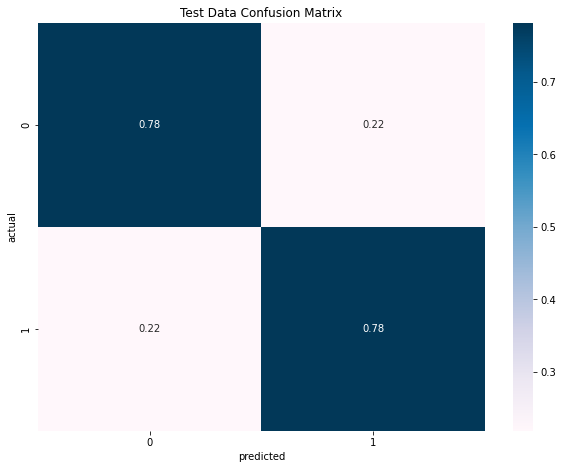

In [242]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.06 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted'], normalize='index'), annot=True, cmap='PuBu')
plt.title('Test Data Confusion Matrix')
plt.show()

train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.06 else 0)

In [243]:
print("A pontuação geral de precisão para a Train Data é: ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("A pontuação geral de precisão para a Test Data é: ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

A pontuação geral de precisão para a Train Data é:  0.7907532467532468
A pontuação geral de precisão para a Test Data é:  0.7801212121212121




**PR-AUC, ROC-AUC** abaixo de **[Regressão Logistica Balanceada](#2.-Regressão-logística-via-modelo-estatístico-com-o-data-set-balanceado).**

----------
## 5. RandomForestClassifier

Neste modelo usarei uma função de otimização como ultima tentativa de encontrar uma ROC acima de ~0.85 do modelo de **[Regressão Logistica Balanceada](#2.-Regressão-logística-via-modelo-estatístico-com-o-data-set-balanceado).**

In [271]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [460]:
# define data set

train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)



In [461]:
train_y = train_X_y['inadimplente']
train_X = train_X_y[train_features]

test_y = test_X_y['inadimplente']
test_X = test_X_y[train_features]


In [274]:
def calibragem_hiperparametros(X, y, potencia_calibragem):
    
    """
    
    Função para calibrar os hiperparâmetros do modelo Random Forest em busca
    da melhor performance no conjunto teste/produção. A função utiliza o
    método RandomSearchCV para fazer uma busca aleatória dentro um conjunto
    predefinido de hiperparâmetros com relação à combinação que exiba melhor
    performance em um conjunto de teste via cross-validation.
    
    Inputs:
        - X: Dataframe de variáveis explicativas.
        - y: Dataframe com a variável-resposta.
    
    Outputs:
        - best: dicionário contendo os hiperparâmetros do melhor modelo.
    
    """
    
    print('calibrando os hiperparâmetros do modelo...')
    print(X.shape, y.shape)

    rf = RandomForestClassifier(random_state = 12345)
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier(random_state = 12345)
    # Random search of parameters
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 10*potencia_calibragem, cv = 3*potencia_calibragem, verbose = 3, random_state = 12345, n_jobs = 6)
    # Fit the random search model

    with joblib.parallel_backend('threading', n_jobs = 6):
        rf_random.fit(X, y)

    best = rf_random.best_params_
    
    print('calibragem finalizada!')
    
    return best

params = calibragem_hiperparametros(train_X, train_y,potencia_calibragem=4)


calibrando os hiperparâmetros do modelo...
(77000, 10) (77000,)
Fitting 6 folds for each of 20 candidates, totalling 120 fits
[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False [CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False [CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 


[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False [CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 

[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, score=0.935, total= 3.7min
[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, score=0.936, total= 3.7min
[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, score=0.934, total= 3.7min
[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, score=0.935, total= 3.8min
[CV] n_estimators=411, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_dep

[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 10.9min


[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, score=0.935, total= 3.4min
[CV] n_estimators=277, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, score=0.935, total= 3.4min
[CV] n_estimators=277, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, score=0.936, total= 3.4min
[CV] n_estimators=277, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=411, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, score=0.936, total= 3.4min
[CV] n_estimators=277, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_dep

[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 41.0min finished


calibragem finalizada!


In [462]:
params

{'n_estimators': 233,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [463]:
# fit the model on the whole data set
model = RandomForestClassifier(**params)
result = model.fit(train_X, train_y)
# predict = result.predict(test_X)



In [464]:
AUC = metrics.average_precision_score(train_y, result.predict(train_X))

print('PR-AUC is -> ' + str(AUC))

PR-AUC is -> 0.404806466909871


In [465]:
AUC = metrics.roc_auc_score(train_y, result.predict(train_X))

print('Train AUC é -> ' + str(AUC))

AUC = metrics.roc_auc_score(test_y, result.predict(test_X))

print('Test AUC é -> ' + str(AUC))

Train AUC é -> 0.6883312686502805
Test AUC é -> 0.5785476982750672


In [466]:
# create prediction tables
train_predicted_prob = pd.DataFrame(result.predict_proba(train_X))
train_predicted_prob = train_predicted_prob[1]
train_predicted_prob.columns = ['prob']
train_actual = train_y.reset_index().drop(labels='index', axis=1)
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict_proba(test_X))
test_predicted_prob = test_predicted_prob[1]
test_predicted_prob.columns = ['prob']
test_actual = test_y.reset_index().drop(labels='index', axis=1)
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

In [467]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in  tqdm(np.linspace(0,1,50)):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:05<00:00,  9.71s/it]


In [468]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.14,1.00,0.93,1.92


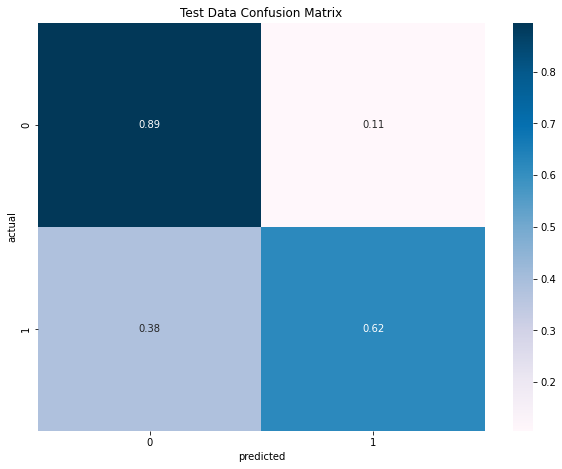

In [471]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.14 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted'], normalize='index'), annot=True, cmap='PuBu')
plt.title('Test Data Confusion Matrix')
plt.show()

train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.14 else 0)

In [472]:
print("A pontuação geral de precisão para a Train Data é: ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("A pontuação geral de precisão para a Test Data é: ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

A pontuação geral de precisão para a Train Data é:  0.9286233766233766
A pontuação geral de precisão para a Test Data é:  0.8760909090909091


------------

Mesmo após a calibragem do hiperparâmetros, o modelo **RandomForestClassifier** ainda apresenta desempenho **inferior** ao modelo de **Regressão Logística** se comparados pela métrica ROC-AUC.

Ainda que o modelo **RandomForestClassifier** tenha melhor performance se utilizarmos a métrica [PR-AUC](https://towardsdatascience.com/choosing-the-right-metric-is-a-huge-issue-99ccbe73de61) continuo considerando o desempenho do modelo de **[Regressão Logistica com dados balanceados](#2.-Regressão-logística-via-modelo-estatístico-com-o-data-set-balanceado)** como sendo o que melhor descreve e prediz a **resolução do problema proposto neste case** e portanto será a partir dele que calcularei a **planilha de resultados** enviada para avaliação.

## 6. Gerando planilha de resultados

## Regressão logística via modelo estatístico

#### Dividindo train e test

In [513]:
train_features = emprestimos.columns.difference(['inadimplente'])
train_X_y, test_X_y = train_test_split(emprestimos, test_size=0.3, random_state=42)

In [514]:
# transformar o data set
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X = train_X_y.drop(labels='inadimplente', axis=1)
y =  train_X_y['inadimplente']
counter = Counter(y)
print('Previous', counter)
X, y = pipeline.fit_resample(X, y)

counter = Counter(y)
print('New' ,counter)

Previous Counter({0: 71804, 1: 5196})
New Counter({0: 14360, 1: 7180})


-----------------------


### Gerando Modelo e  conferindo resultados 

In [515]:
train_y = pd.DataFrame(y, columns=['inadimplente'])
train_X_y = train_y.merge(X, how='left', left_index=True, right_index=True)

In [516]:
logreg = sm.logit(formula='inadimplente ~ ' + "+".join(train_features), data=train_X_y)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.458286
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           inadimplente   No. Observations:                21540
Model:                          Logit   Df Residuals:                    21529
Method:                           MLE   Df Model:                           10
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.2800
Time:                        20:00:30   Log-Likelihood:                -9871.5
converged:                       True   LL-Null:                       -13711.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -1.6008      0.085    -18.863      0.000      -1.767      -1.434
idade                                    -0.0197      0.001    -13.918      0.000      -0.022      -0.017
numero_de_dependentes                     0.0487      0.017      2.948      0.003       0.016       0.081
numero_de_vezes_que_passou_60_89_dias     0.6880      0.053     12.917      0.000       0.584       0.792
numero_emprestimos_imobiliarios          -0.0248      0.021     -1.171      0.242      -0.066       0.017
numero_linhas_crdto_aberto                0.0487      0.004     11.763      0.000       0.041       0.057
numero_vezes_passou_90_dias               0.8870      0.041     21.879      0.000       0.808       0.966
razao_debito                          -4.274e-06   1.99e-05     -0.215      0.830   -4.33e-05    3.48e-05
salario_mensal                        -1.705e-05    5.1e-06     -3.345      0.001    -2.7e-05   -7.06e-06
util_linhas_inseguras                     2.1893      0.051     42.652      0.000       2.089       2.290
vezes_passou_de_30_59_dias                0.5216      0.024     22.170      0.000       0.475       0.568
=========================================================================================================
"""

In [517]:
AUC = metrics.average_precision_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features]))

print('PR-AUC is -> ' + str(AUC))

PR-AUC is -> 0.3617625514827067


In [518]:
AUC = metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features]))

print('Train AUC é -> ' + str(AUC))

AUC = metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features]))

print('Test AUC é -> ' + str(AUC))

Train AUC é -> 0.847240943195661
Test AUC é -> 0.8460855102544851


In [519]:
train_gini = 2*metrics.roc_auc_score(train_X_y['inadimplente'], result.predict(train_X_y[train_features])) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X_y['inadimplente'], result.predict(test_X_y[train_features])) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.694481886391322
The Gini Index for the model built on the Test Data is :  0.6921710205089702


In [520]:
train_predicted_prob = pd.DataFrame(result.predict(train_X_y[train_features]))
train_predicted_prob.columns = ['prob']
train_actual = train_X_y['inadimplente']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict(test_X_y[train_features]))
test_predicted_prob.columns = ['prob']
test_actual = test_X_y['inadimplente']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in  tqdm(np.linspace(0,1,50)):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.73s/it]


In [521]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.29,0.79,0.75,1.54


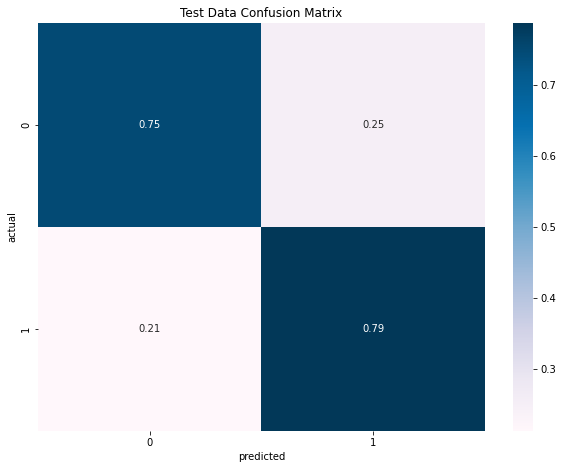

In [522]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted'], normalize='index'), annot=True, cmap='PuBu')
plt.title('Test Data Confusion Matrix')
plt.show()

train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)


**Agora que me certifiquei de que o modelo está salvo e rodando irei gerar a tabela de previsões para o mesmo.**



In [538]:
teste = pd.read_csv('teste.csv')
teste=teste.apply(lambda x: outlier_capping(x))
teste=teste.apply(lambda x: Missing_imputation(x))

teste

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.03,62,0,0.08,8180.00,3,0,2,0,0.00
1,0.67,55,0,0.15,2200.00,3,0,0,0,0.00
2,0.01,44,0,0.15,7499.00,20,0,1,0,0.00
3,0.09,54,0,0.35,5900.00,15,0,1,1,0.00
4,0.11,54,0,0.07,2167.00,3,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...
39995,0.00,68,1,0.06,10833.00,9,1,0,0,0.00
39996,0.06,84,0,0.01,8456.00,7,0,0,0,0.00
39997,0.82,70,0,0.66,6000.00,17,0,2,0,0.00
39998,0.11,64,2,0.87,5045.00,12,0,4,0,0.00


In [539]:
teste['inadimplente'] = result.predict(teste)
teste['inadimplente'] = teste['inadimplente'].apply(lambda x: 1 if x > 0.29 else 0)


In [542]:
cols =  ['inadimplente', 'util_linhas_inseguras', 'idade',
        'vezes_passou_de_30_59_dias', 'razao_debito', 'salario_mensal',
        'numero_linhas_crdto_aberto', 'numero_vezes_passou_90_dias',
        'numero_emprestimos_imobiliarios',
        'numero_de_vezes_que_passou_60_89_dias', 'numero_de_dependentes']

In [544]:
teste[cols].to_csv('resposta_ao_teste_Joao_Aguilera.csv')
teste[cols]

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0,0.03,62,0,0.08,8180.00,3,0,2,0,0.00
1,0,0.67,55,0,0.15,2200.00,3,0,0,0,0.00
2,0,0.01,44,0,0.15,7499.00,20,0,1,0,0.00
3,0,0.09,54,0,0.35,5900.00,15,0,1,1,0.00
4,0,0.11,54,0,0.07,2167.00,3,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0.00,68,1,0.06,10833.00,9,1,0,0,0.00
39996,0,0.06,84,0,0.01,8456.00,7,0,0,0,0.00
39997,1,0.82,70,0,0.66,6000.00,17,0,2,0,0.00
39998,0,0.11,64,2,0.87,5045.00,12,0,4,0,0.00
